# **Analyze Vrij by integrating with ingest**

I try to fix the standard to add on the EBs dataset.

In [100]:
import scanpy as sc
import anndata as ad
import pandas as pd
from collections import defaultdict
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [101]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150, facecolor='white', fontsize=12)

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 louvain==0.8.2 pynndescent==0.5.13


**Read the standard object**

In [102]:
adata_ref = ad.read_h5ad('Processing/Vrij/Objects/object_1_Deng_filtered_1_2_Chen_filtered_1_3_Mohammed_filtered_1_4_Nowo_filtered_1_4bis_Nowo_filtered_1_5_Posfai_filtered_1_6_Arg_filtered_1.h5ad')
print(adata_ref)

AnnData object with n_obs × n_vars = 636 × 32330
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes'


**Read the EBs object**

In [103]:
adata = ad.read_h5ad('Processing/Vrij/Objects/object_7_Vrij_filtered_1.h5ad') 
print(adata)
print(adata_ref)

AnnData object with n_obs × n_vars = 421 × 28110
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
AnnData object with n_obs × n_vars = 636 × 32330
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes'


**Take genes present in the 2 datasets**

In [104]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

**Normalize data and search highly variable genes**

In [105]:
# Data normalization
sc.pp.normalize_total(adata_ref, target_sum=1e4)
sc.pp.normalize_total(adata, target_sum=1e4)

# Log on datas
sc.pp.log1p(adata_ref)
sc.pp.log1p(adata)

# Stock data logs 
adata_ref.raw = adata_ref
adata.raw = adata

# Scale the data
sc.pp.scale(adata_ref)
sc.pp.scale(adata)

# Highly variable genes
sc.pp.highly_variable_genes(adata_ref)
sc.pp.highly_variable_genes(adata)

normalizing counts per cell
    finished (0:00:00)


C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


**Run PCA**

computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


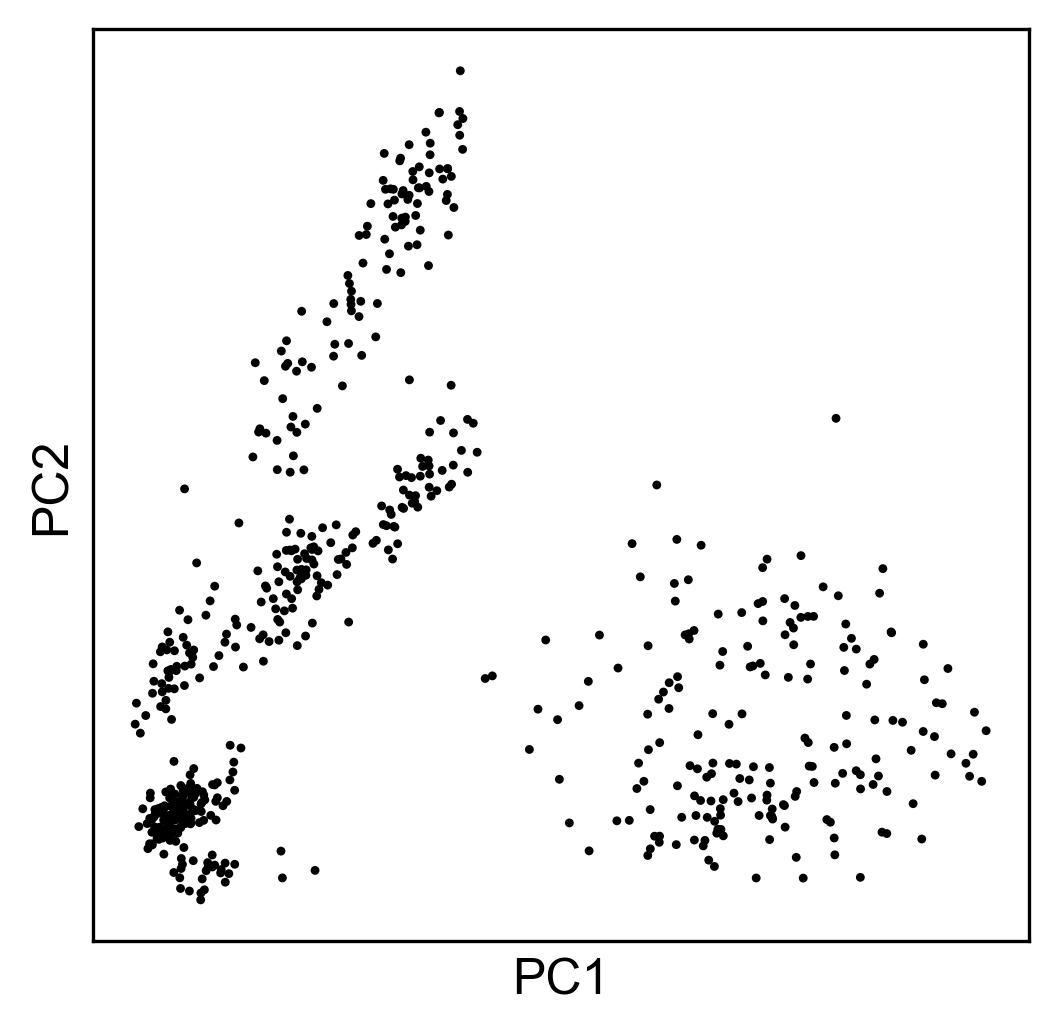

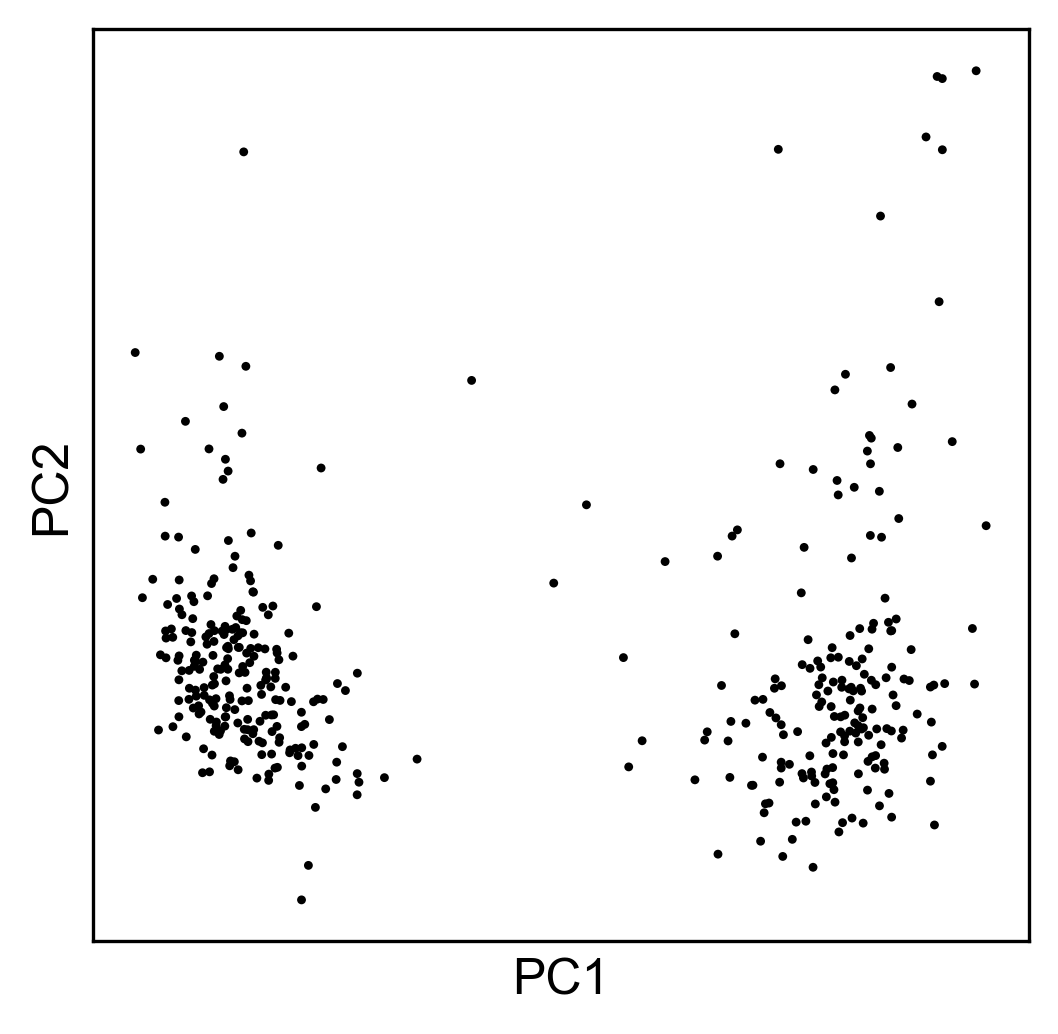

In [106]:
# Run PCA
sc.tl.pca(adata_ref)
sc.tl.pca(adata)
# PCA plot
sc.pl.pca(adata_ref, size=18, na_color = 'black')
sc.pl.pca(adata, size=18, na_color = 'black')

**Run harmony and find neighbors**

In [107]:
sc.external.pp.harmony_integrate(adata_ref, 'dataset', theta = 1, max_iter_harmony = 10, nclust = 3)
# Save new PCA
adata_ref.obsm['X_pca'] = adata_ref.obsm['X_pca_harmony']

2024-07-09 15:54:08,869 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
2024-07-09 15:54:10,017 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-07-09 15:54:10,025 - harmonypy - INFO - Iteration 1 of 10
2024-07-09 15:54:10,077 - harmonypy - INFO - Iteration 2 of 10
2024-07-09 15:54:10,148 - harmonypy - INFO - Iteration 3 of 10
2024-07-09 15:54:10,198 - harmonypy - INFO - Converged after 3 iterations


In [108]:
# Find neighbors
sc.pp.neighbors(adata_ref, n_neighbors=50, n_pcs=20)
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20)
# Make groups
sc.tl.louvain(adata_ref, resolution=0.8)
sc.tl.louvain(adata, resolution=0.8)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


**Run UMAP to verify the standard**

In [109]:
# Run UMAP
sc.tl.umap(adata_ref)
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


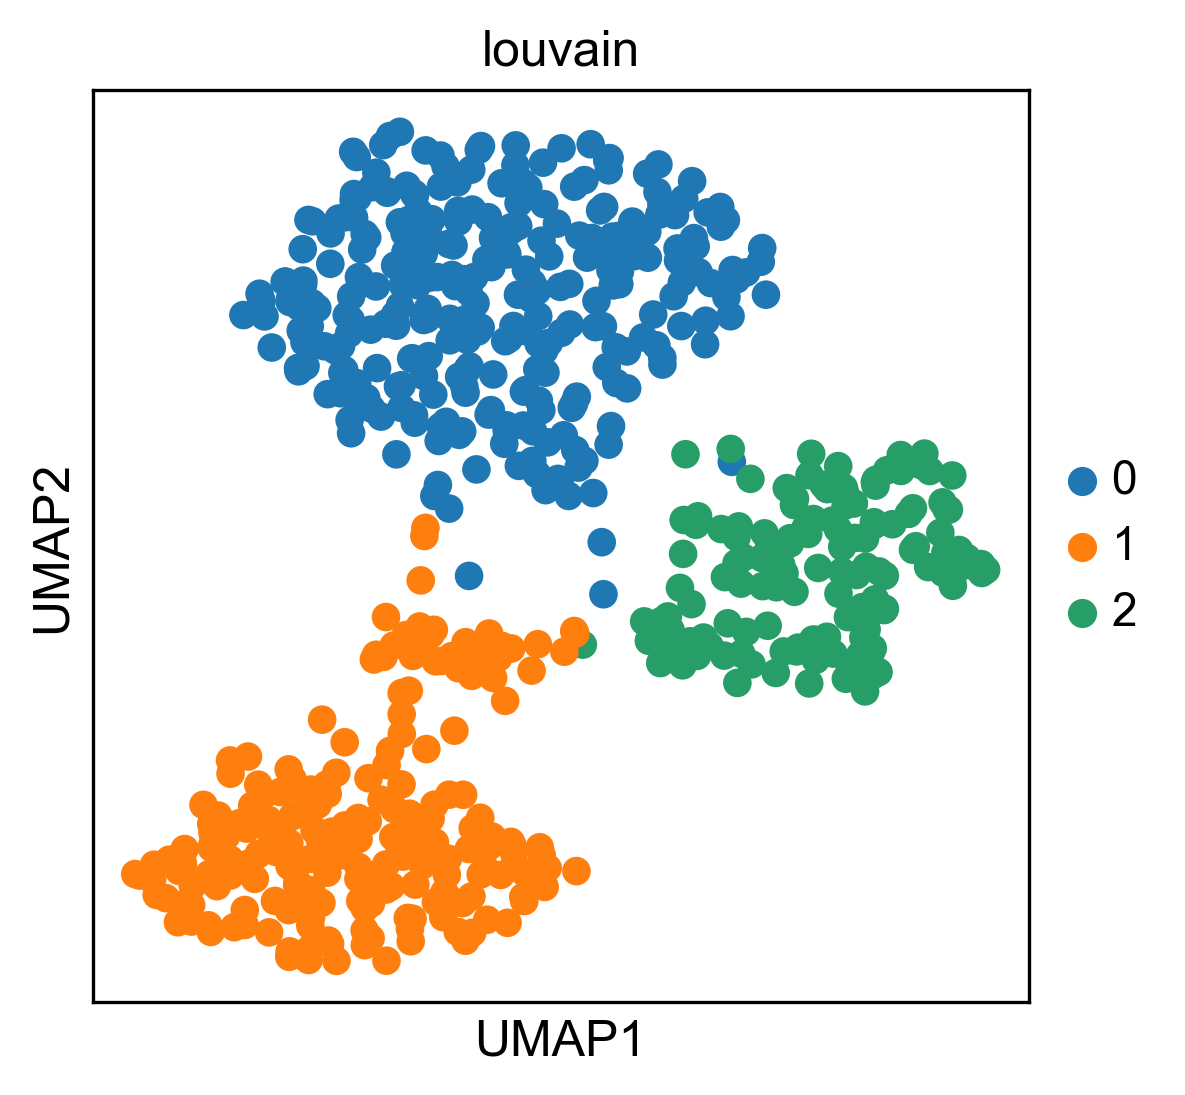

In [110]:
sc.pl.umap(adata_ref, color="louvain")

**Integrates embeddings and annotations of EBs with the standard through projecting on a PCA**

In [111]:
sc.tl.ingest(adata, adata_ref, obs="louvain")

running ingest


C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:04)


**Fix colors to have the same colors**

In [112]:
adata.uns["louvain_colors"] = adata_ref.uns["louvain_colors"]  # fix colors

**Merge the 2 datasets**

In [113]:
adata_concat = adata_ref.concatenate(adata, batch_categories=["ref", "new"])

C:\Users\learogue\AppData\Local\Temp\ipykernel_6512\327172098.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = adata_ref.concatenate(adata, batch_categories=["ref", "new"])


In [114]:
adata_concat.obs.louvain = adata_concat.obs.louvain.astype("category")

# fix category colors
adata_concat.uns["louvain_colors"] = adata_ref.uns["louvain_colors"]

**Plot UMAPs**

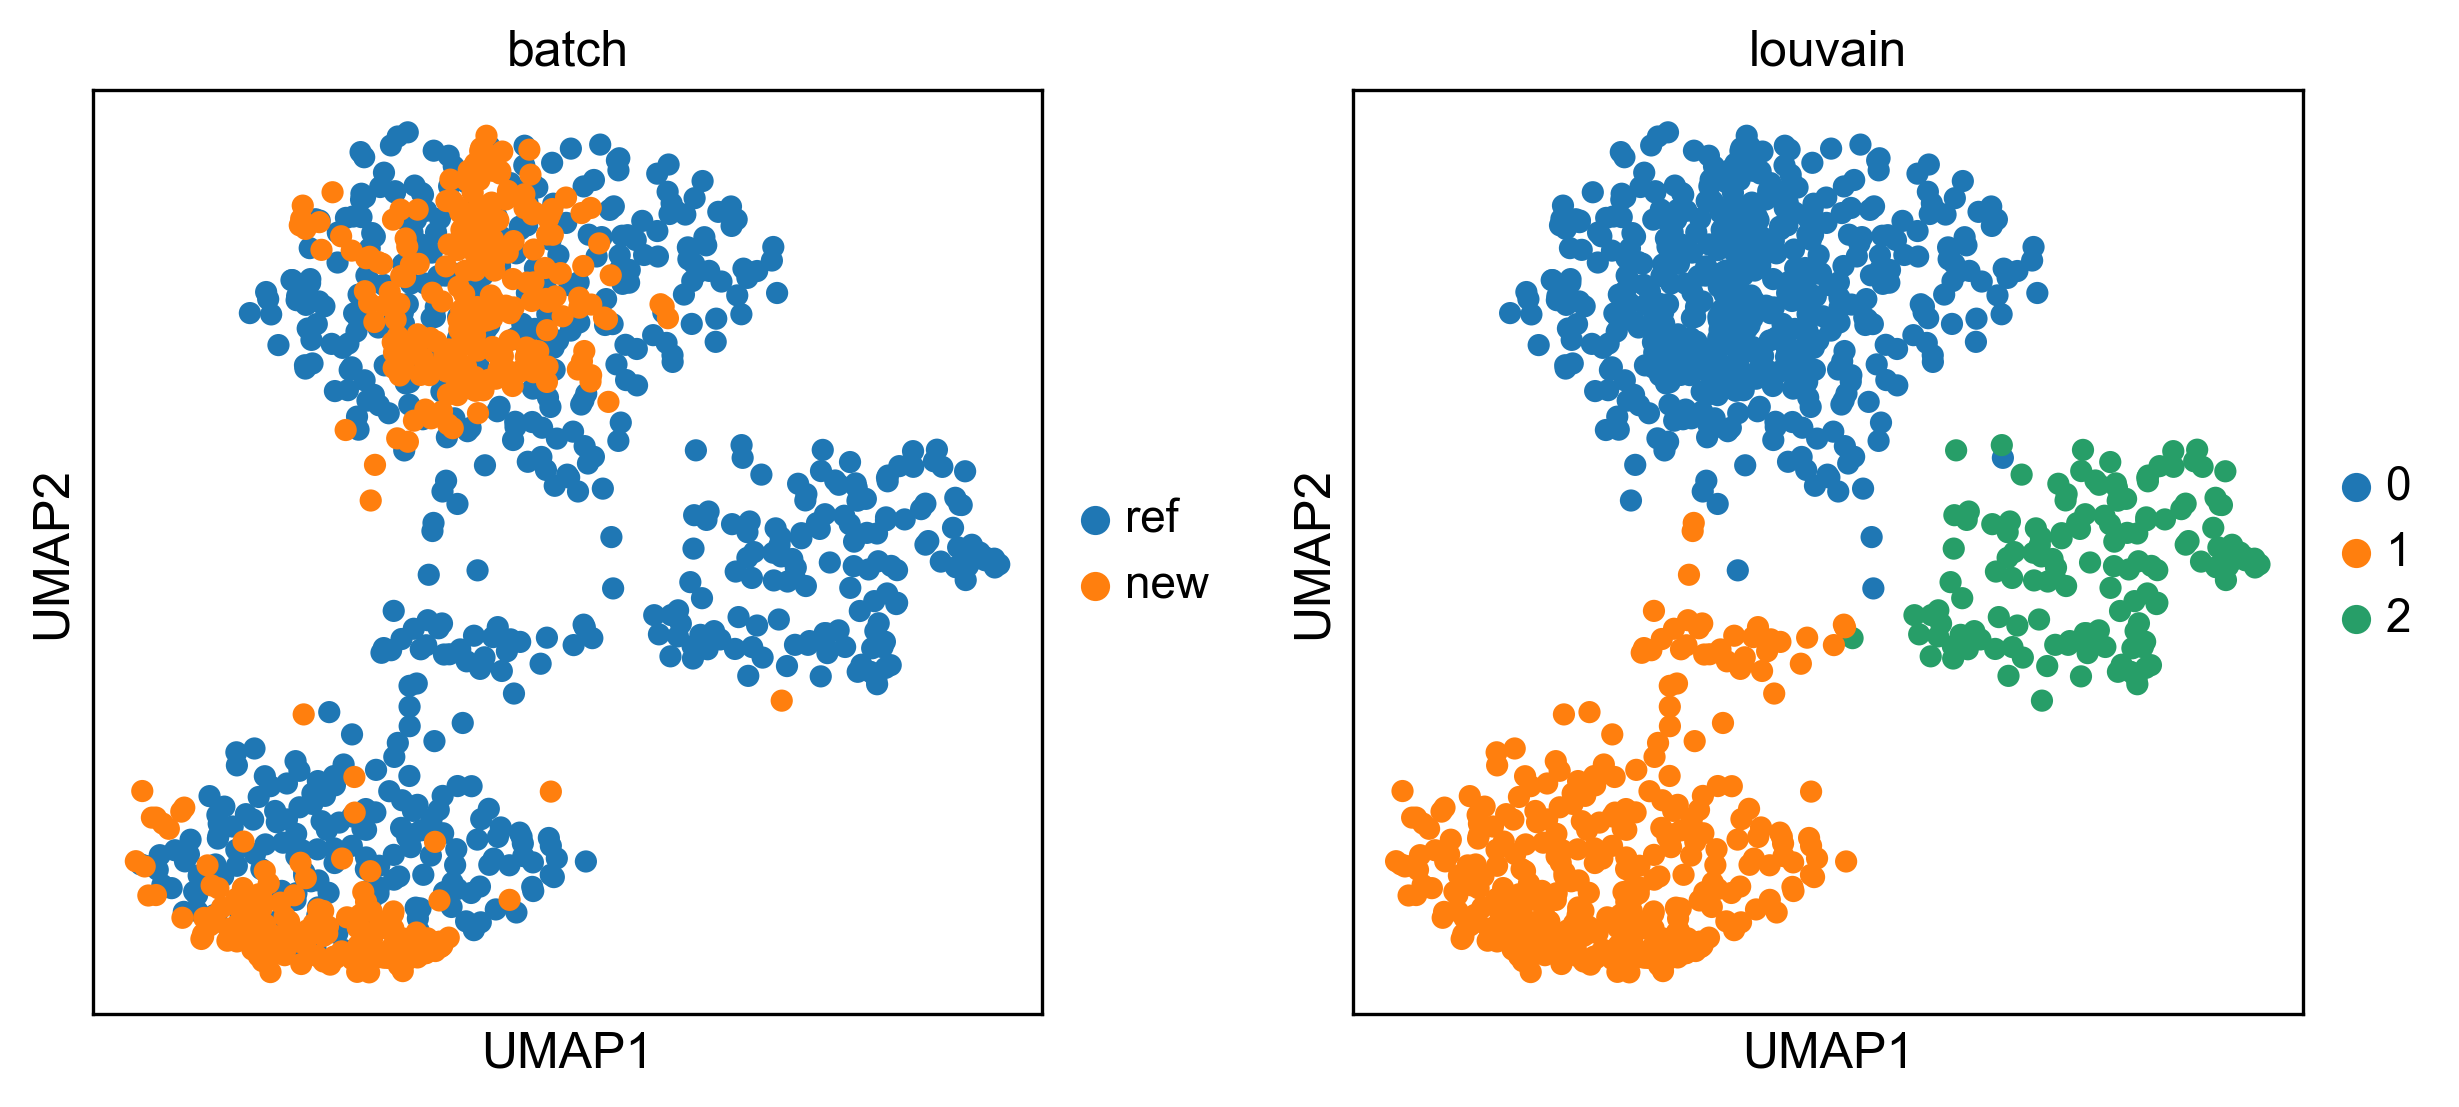

In [115]:
sc.pl.umap(adata_concat, color=["batch", "louvain"])

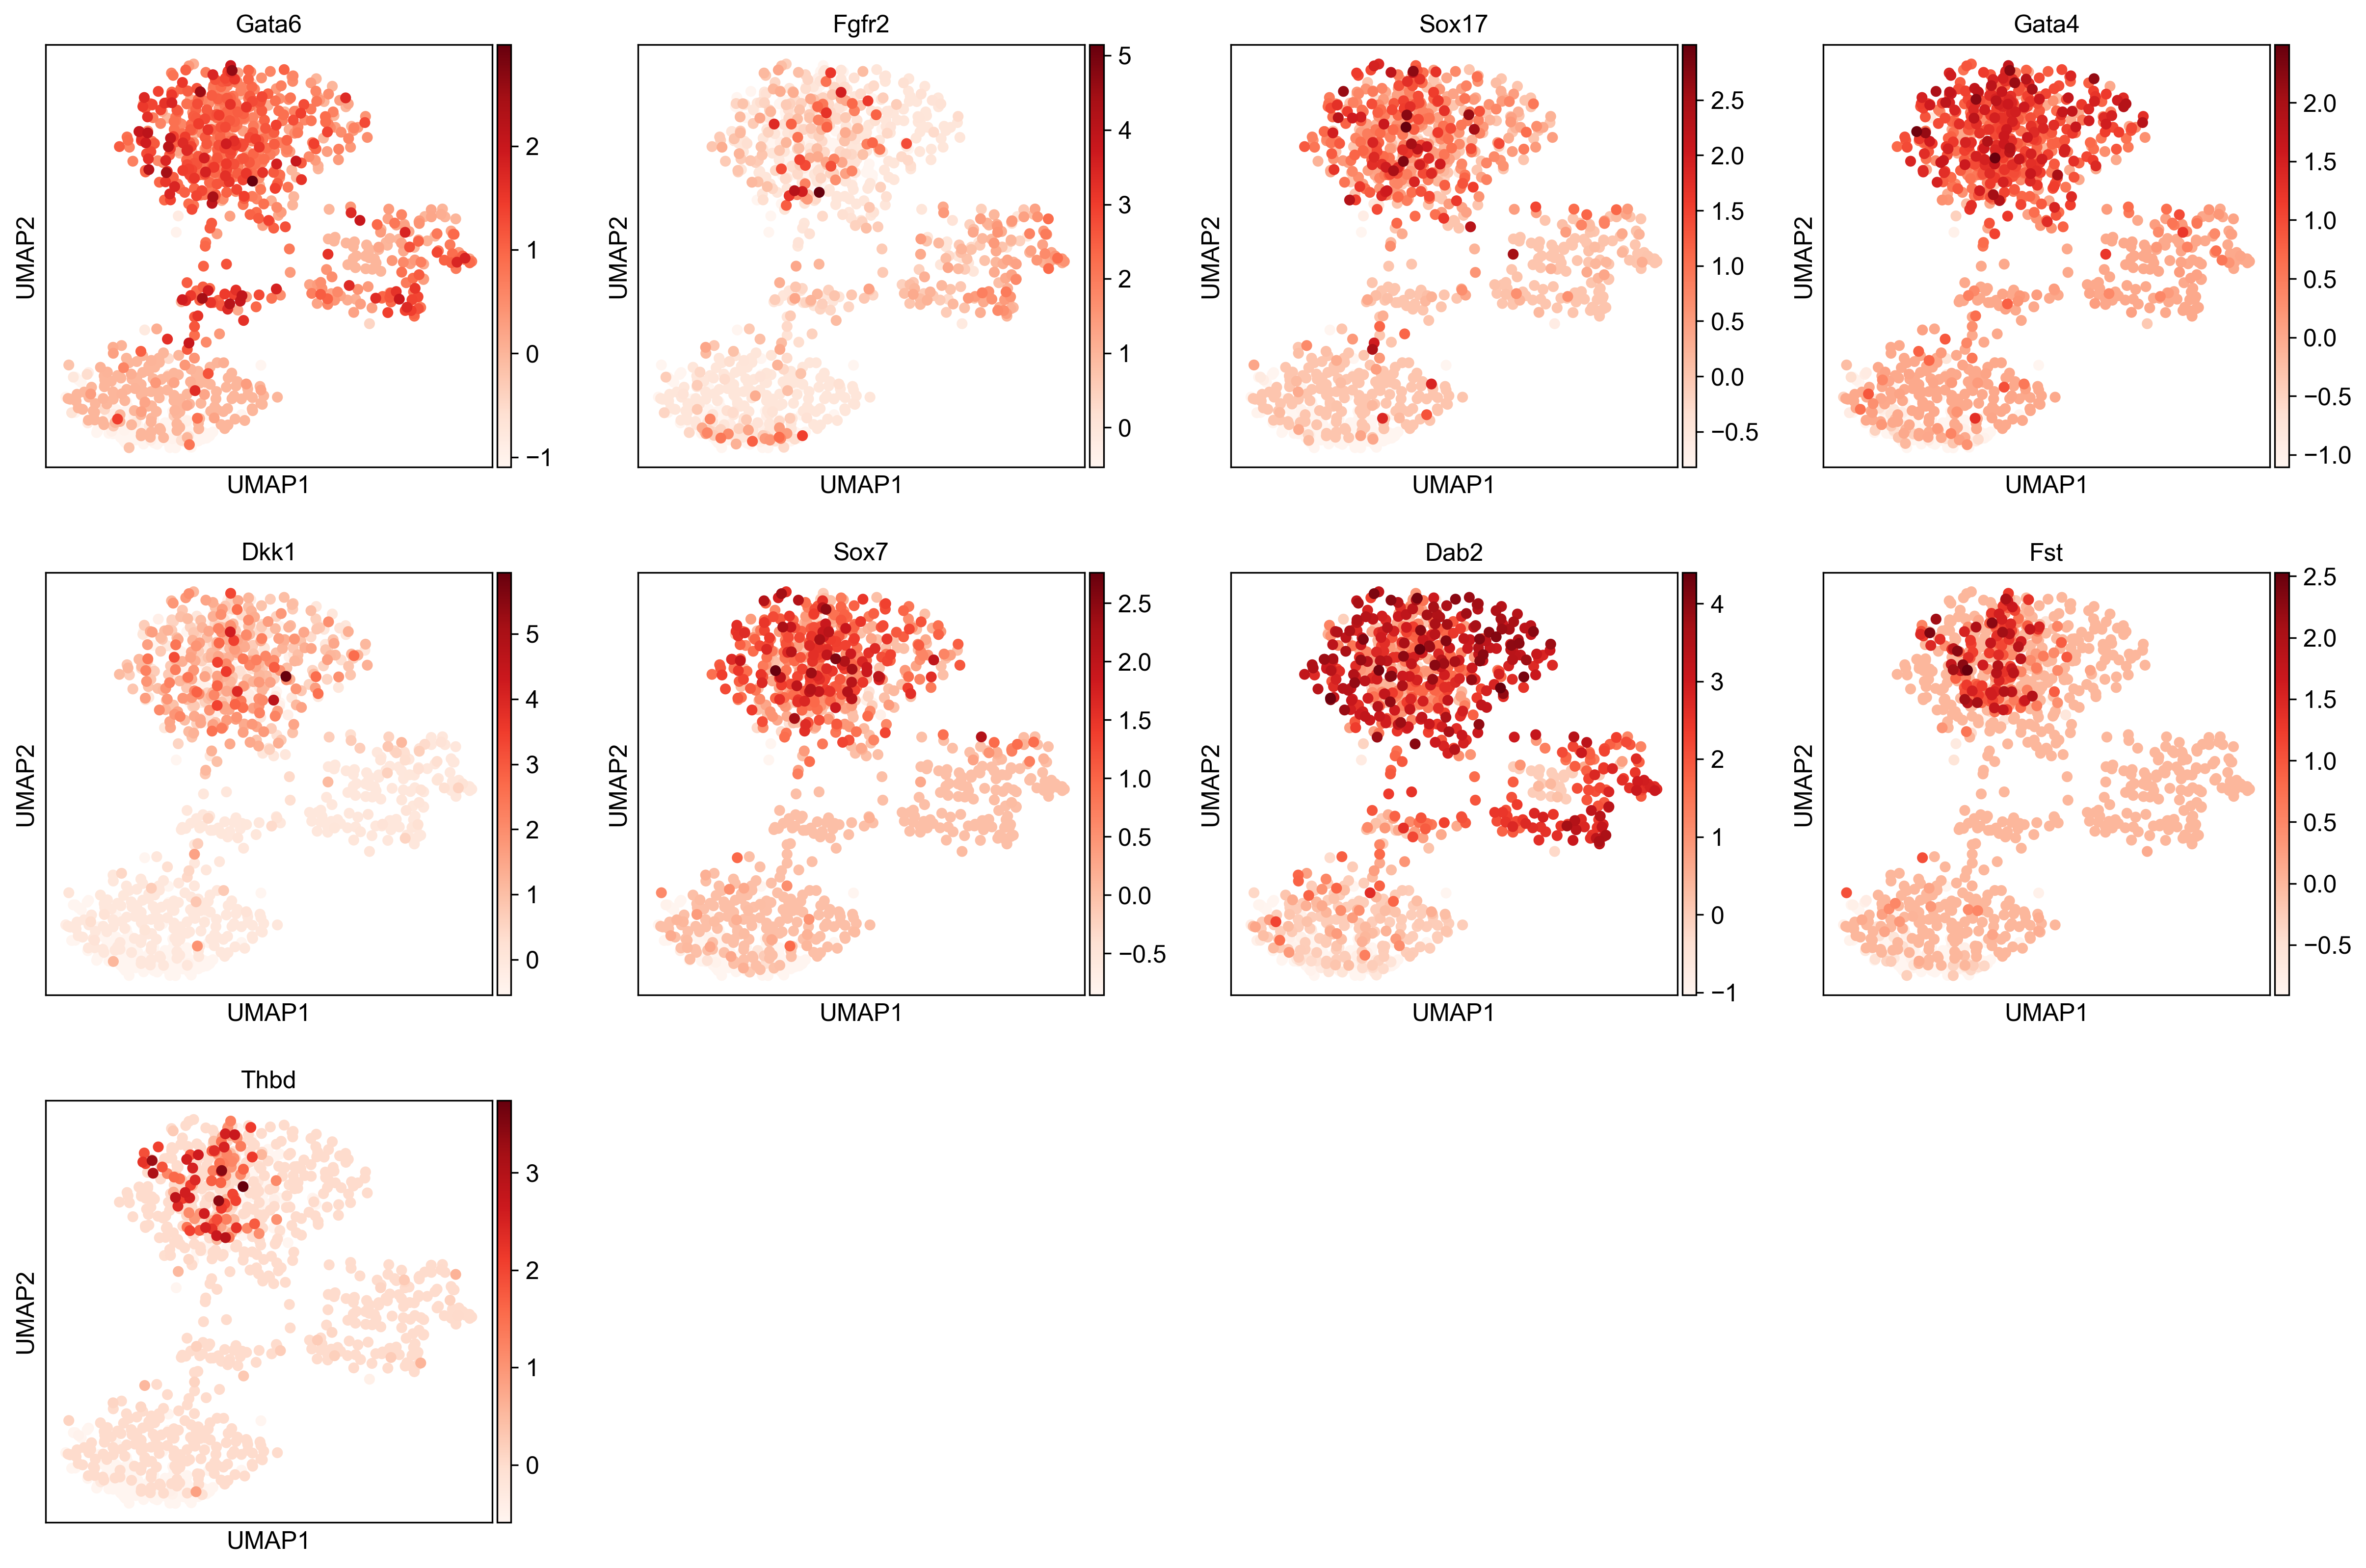

In [116]:
sc.pl.umap(adata_concat, color=['Gata6', 'Fgfr2', 'Sox17', 'Gata4', 'Dkk1', 'Sox7', 'Dab2', 'Fst', 'Thbd'], legend_loc='on data', color_map=mpl.cm.Reds)

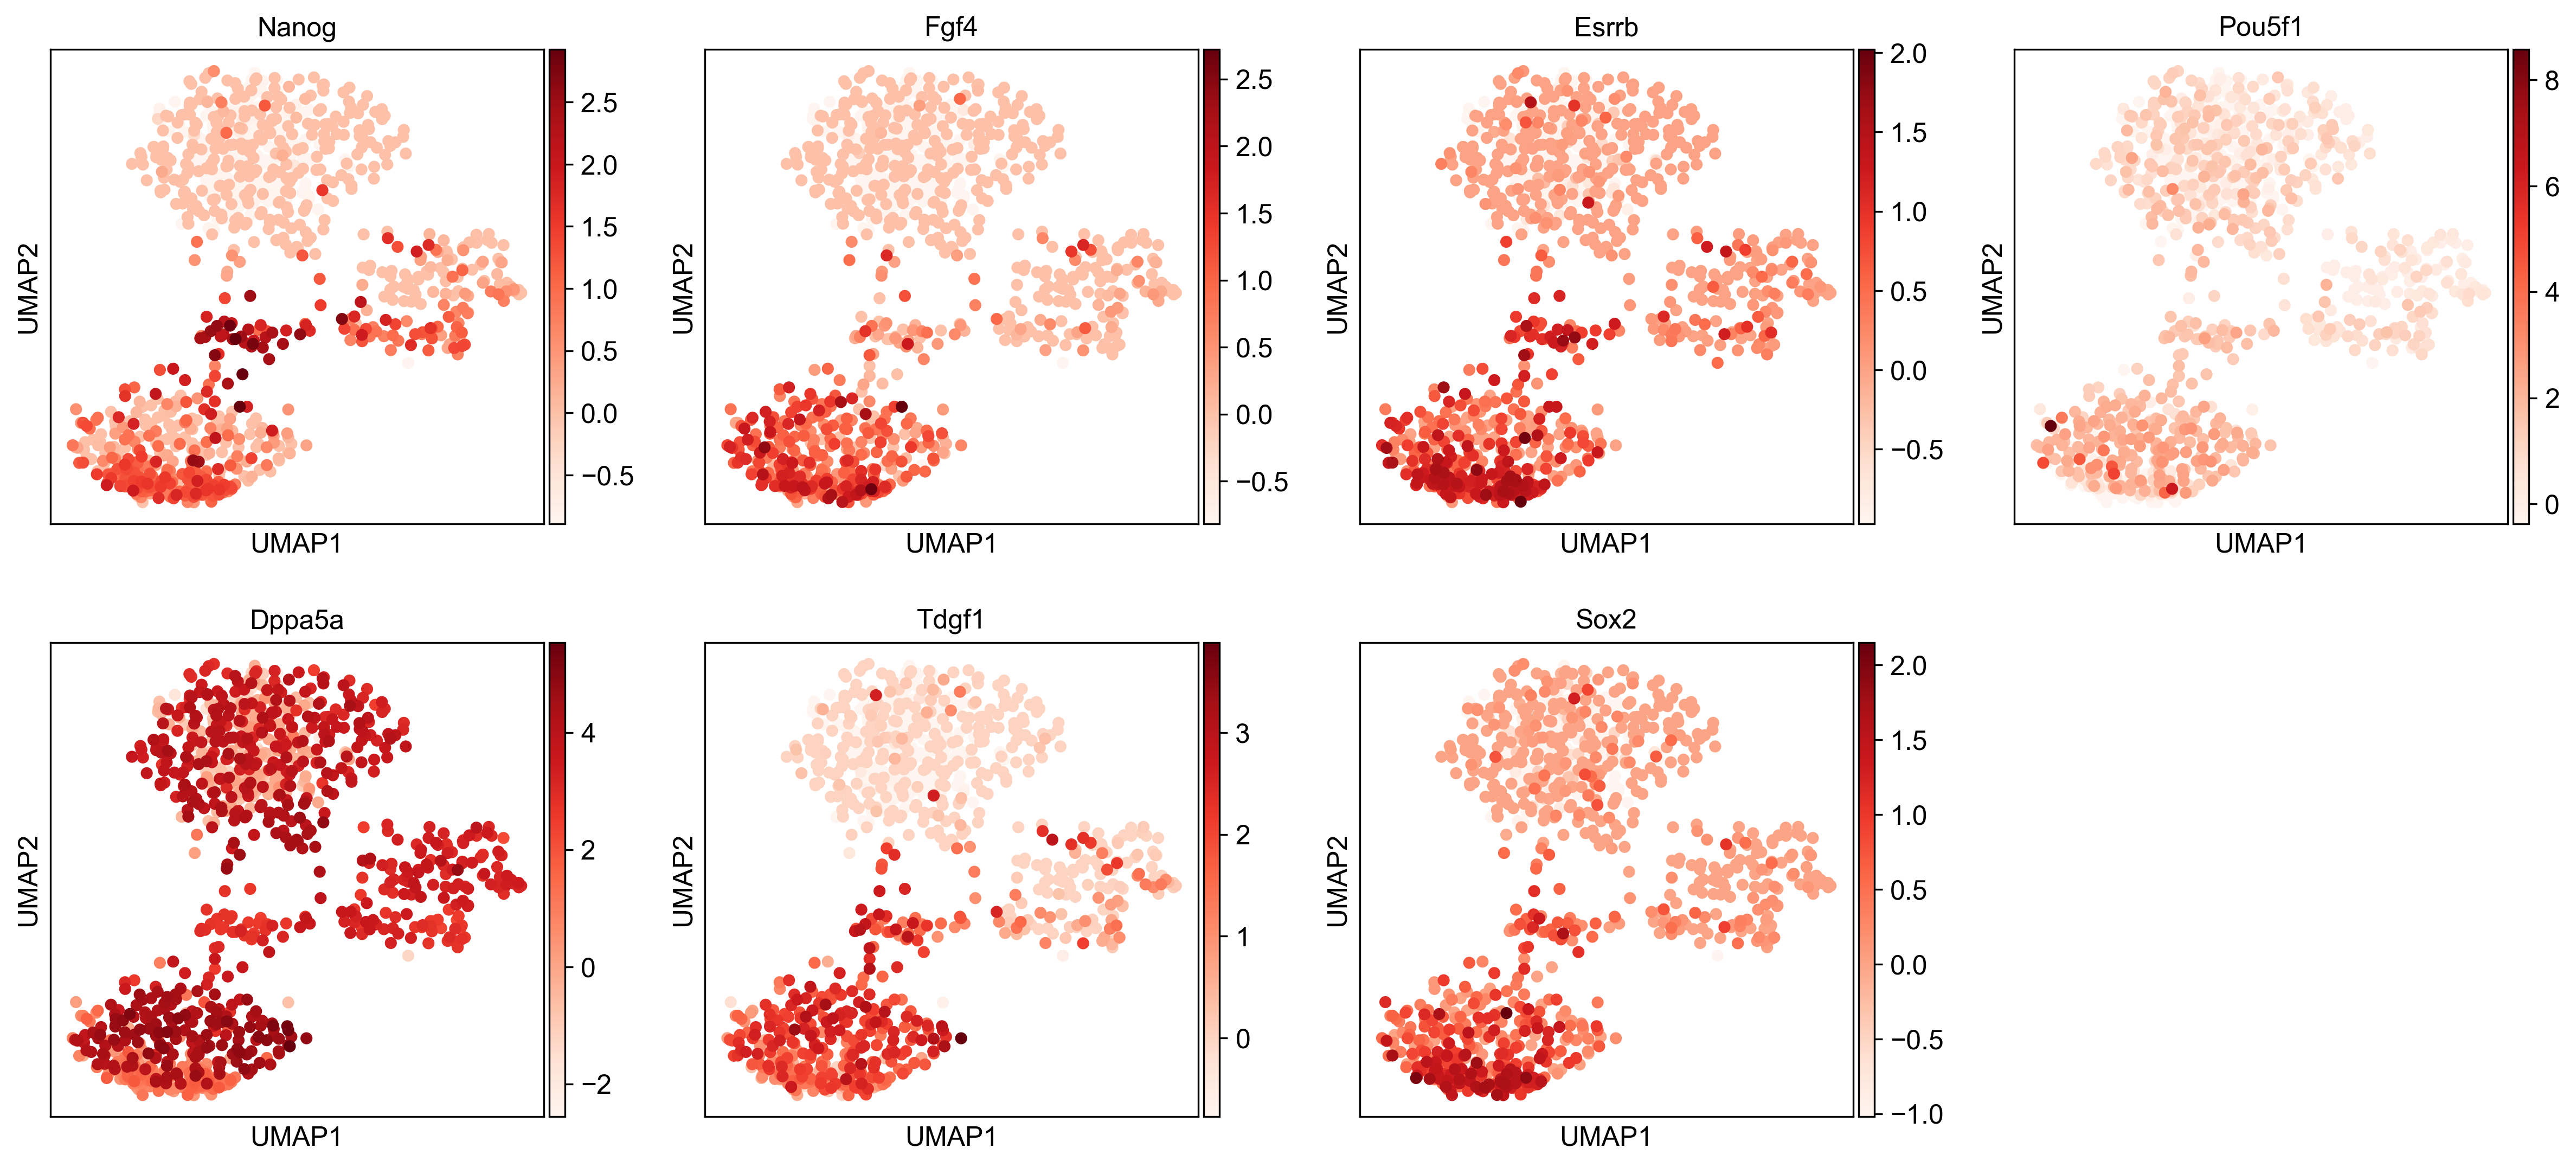

In [117]:
sc.pl.umap(adata_concat, color=['Nanog', 'Fgf4', 'Esrrb', 'Pou5f1', 'Dppa5a', 'Tdgf1', 'Sox2'], legend_loc='on data', color_map=mpl.cm.Reds)

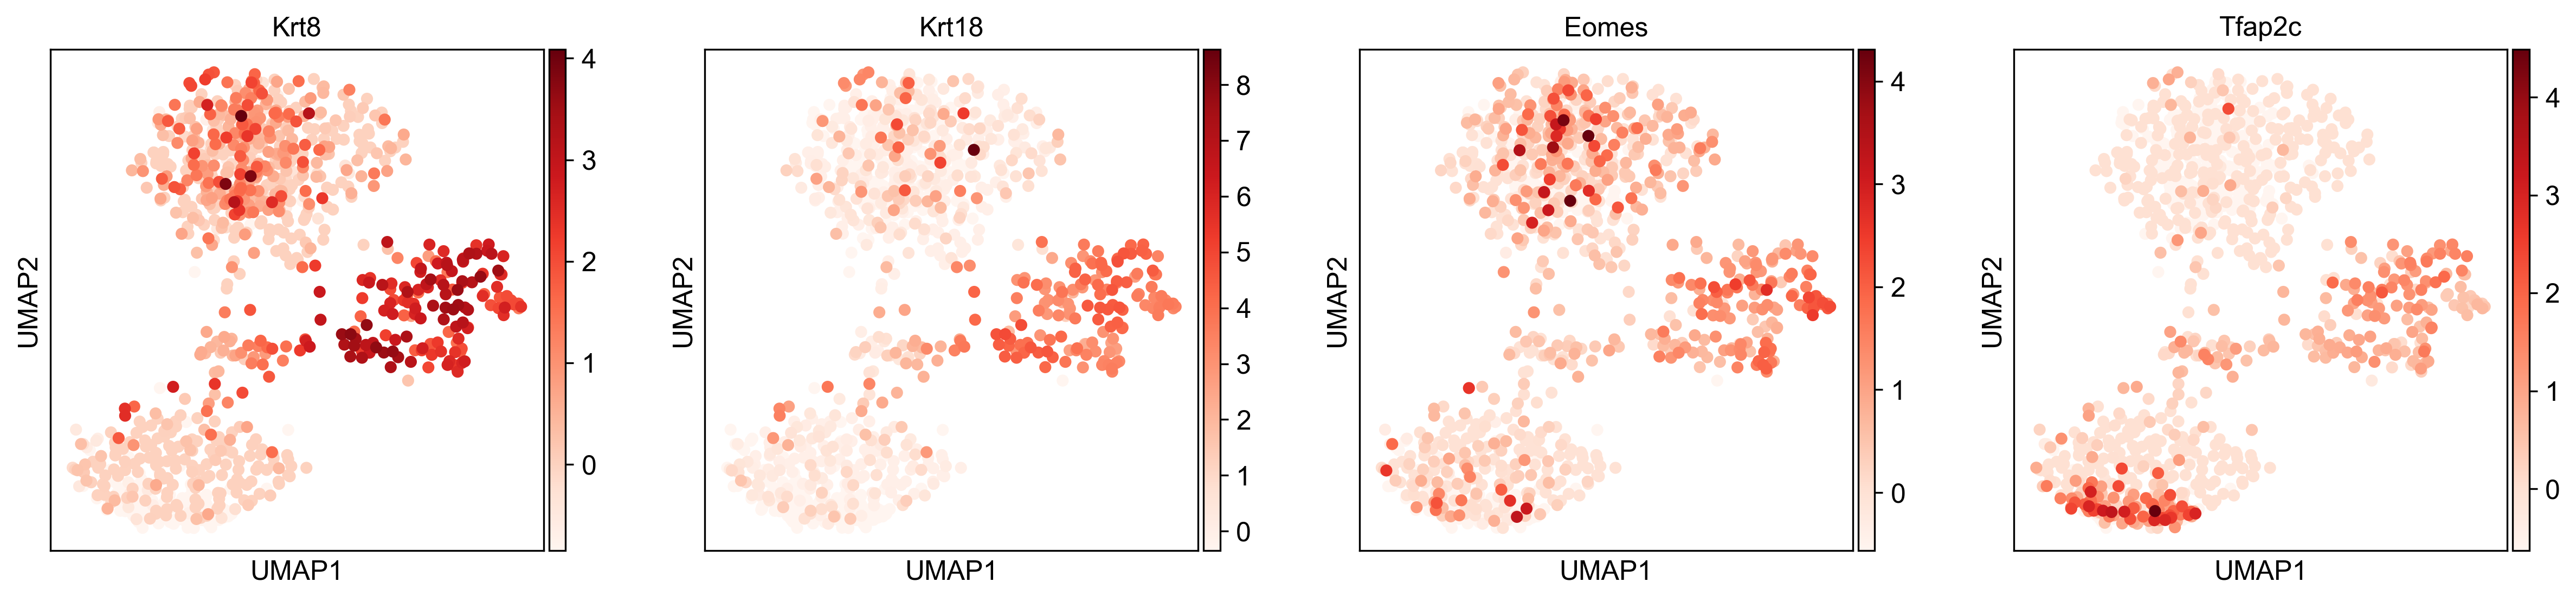

In [118]:
sc.pl.umap(adata_concat, color=['Krt8', 'Krt18', 'Eomes', 'Tfap2c'], legend_loc='on data', color_map=mpl.cm.Reds)

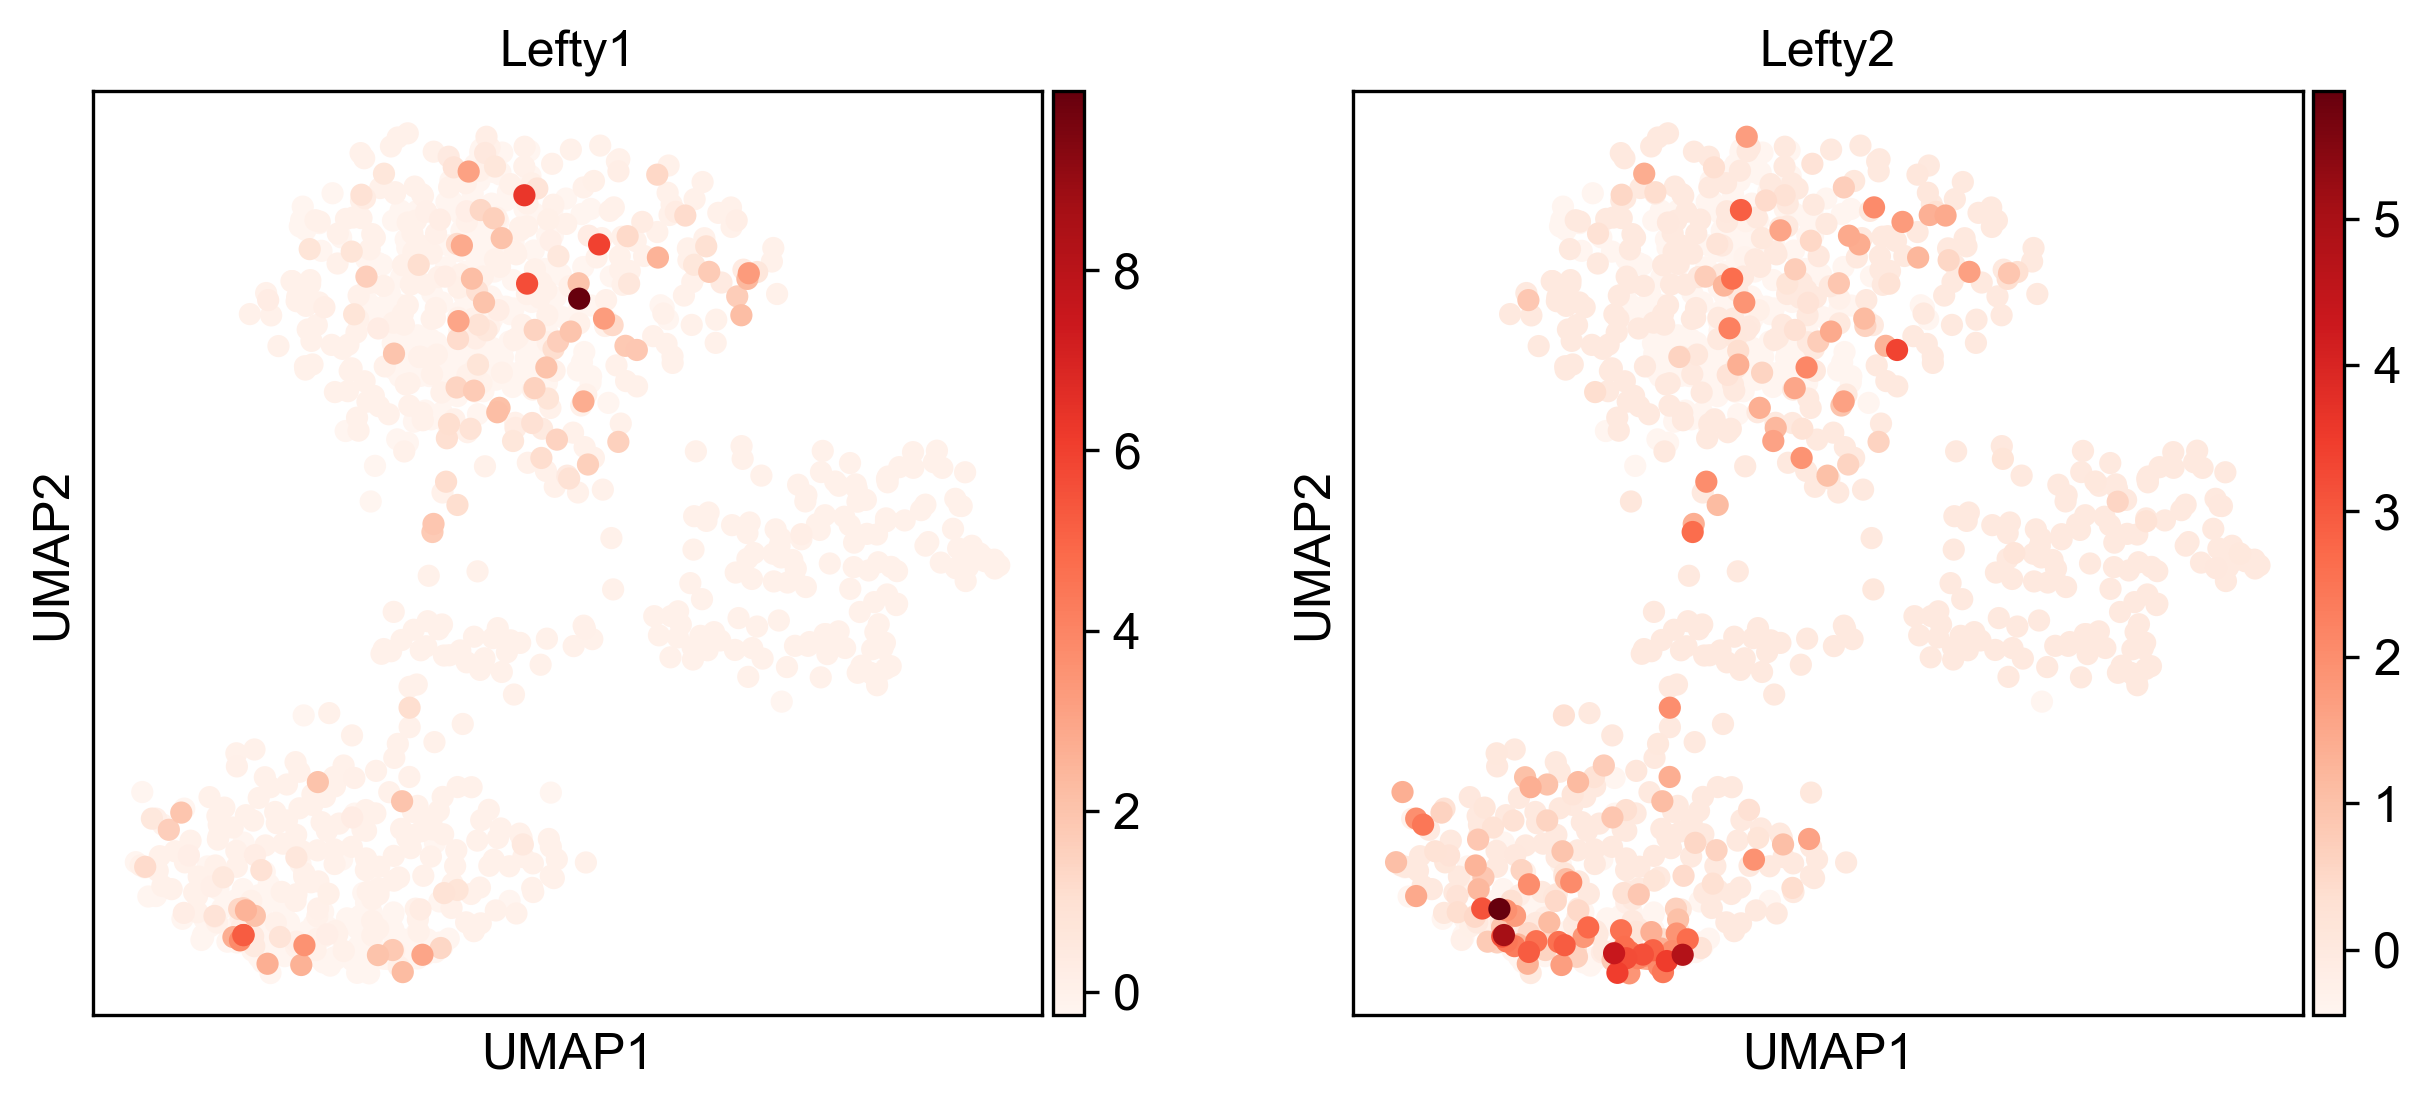

In [119]:
sc.pl.umap(adata_concat, color=['Lefty1', 'Lefty2'], legend_loc='on data', color_map=mpl.cm.Reds)

**Add cell types**

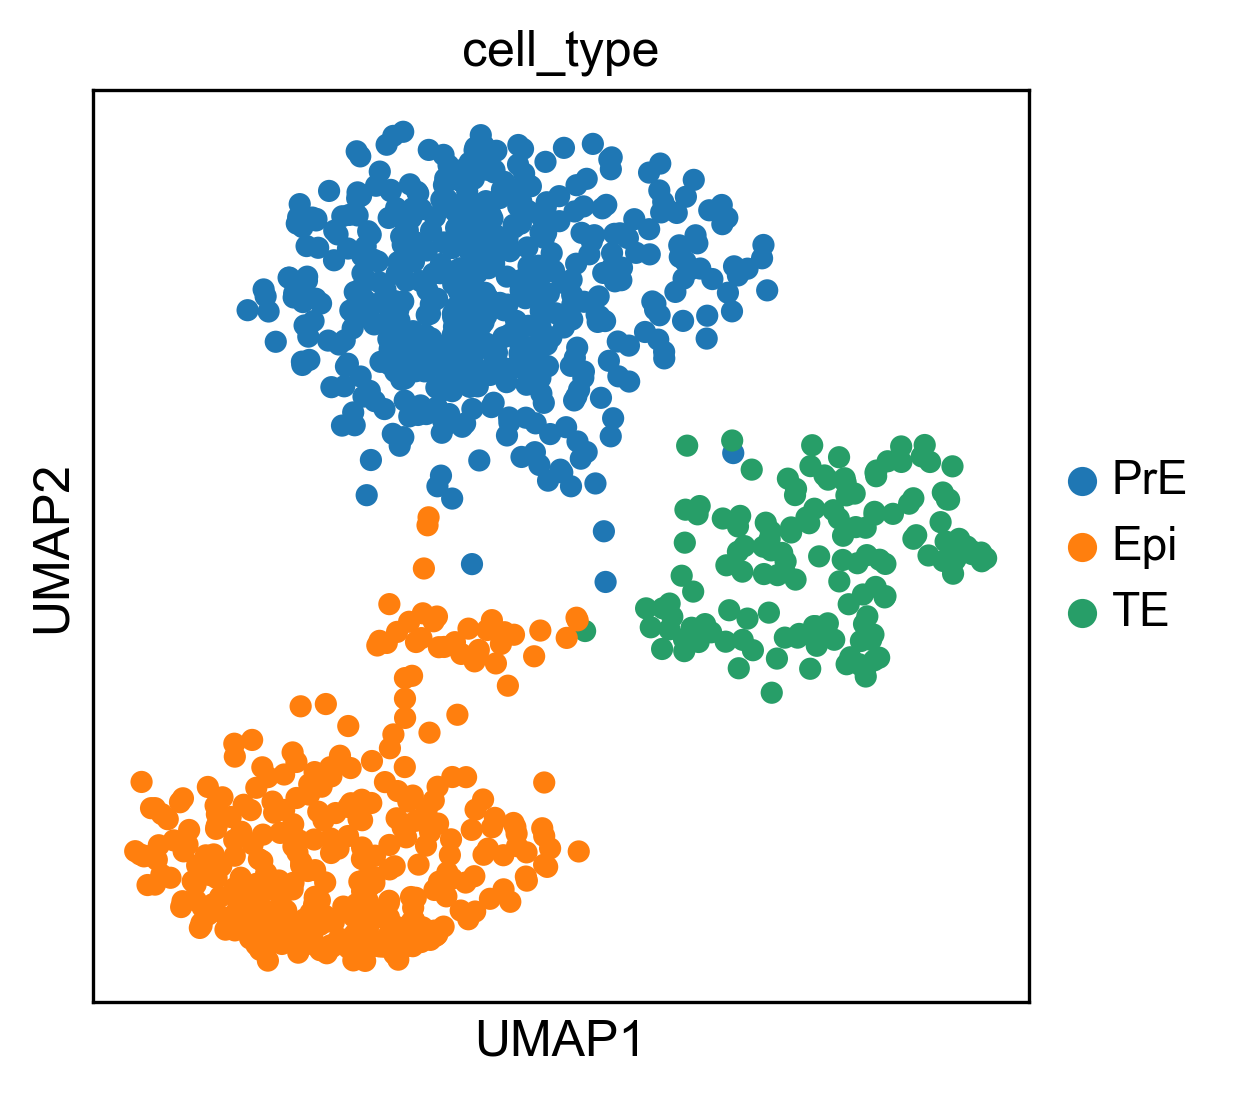

In [120]:
# Add cell types
adata_concat.obs['cell_type'] = adata_concat.obs['louvain']

new_cluster_names = ['PrE', 'Epi', 'TE']
adata_concat.rename_categories("cell_type", new_cluster_names)

sc.pl.umap(adata_concat, color=['cell_type'])

## **DEG between EB and embryos for Epi**

**Sort data**

In [121]:
adata_Vrij_epi = adata_concat[adata_concat.obs['cell_type'] == 'Epi']
adata_Vrij_epi = adata_Vrij_epi[adata_Vrij_epi.obs['dataset'] == '7_Vrij']
print(adata_Vrij_epi)

adata_embr_epi = adata_concat[adata_concat.obs['cell_type'] == 'Epi']
adata_embr_epi = adata_embr_epi[adata_embr_epi.obs['dataset'] != '7_Vrij']
print(adata_embr_epi)

adata_Vrij_epi.obs['model'] = adata_Vrij_epi.n_obs * ['EB']
adata_embr_epi.obs['model'] = adata_embr_epi.n_obs * ['Embryo']

adata_Vrij_embr_epi = ad.concat([adata_Vrij_epi, adata_embr_epi], join='outer')

View of AnnData object with n_obs × n_vars = 189 × 25154
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes', 'louvain', 'batch', 'cell_type'
    var: 'mean-new', 'std-new', 'highly_variable-new', 'means-new', 'dispersions-new', 'dispersions_norm-new', 'mt-new', 'n_cells_by_counts-new', 'mean_counts-new', 'pct_dropout_by_counts-new', 'total_counts-new', 'n_cells-new', 'mean-ref', 'std-ref', 'highly_variable-ref', 'means-ref', 'dispersions-ref', 'dispersions_norm-ref'
    uns: 'louvain_colors', 'batch_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
View of AnnData object with n_obs × n_vars = 208 × 25154
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes', 'louvain', 'batch', 'cell_type'
    var: 'mean-new', 'std-new', 'highly_variable-new', 'means-new', 'dispersions-new', 'dispersions_norm-new', 'mt-new', 'n_cells_by_counts-new', 'mean_counts-new', 'pct_dropout_by_counts-new', 

C:\Users\learogue\AppData\Local\Temp\ipykernel_6512\3528636435.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_Vrij_epi.obs['model'] = adata_Vrij_epi.n_obs * ['EB']
C:\Users\learogue\AppData\Local\Temp\ipykernel_6512\3528636435.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_embr_epi.obs['model'] = adata_embr_epi.n_obs * ['Embryo']


**Save genes**

In [122]:
adata_epi = adata_concat[adata_concat.obs['cell_type'] == 'Epi']
l=adata_epi.var_names.to_list()

with open('epi_genes_tot.txt', 'w') as f:
    for gene in l:
        print(gene, file=f)

In [123]:
print(adata_Vrij_epi.var_names)

Index(['0610005C13Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik',
       '0610010F05Rik', '0610010K14Rik', '0610012G03Rik', '0610030E20Rik',
       '0610038B21Rik', '0610039K10Rik',
       ...
       'mt-Tq', 'mt-Tt', 'mt-Tv', 'n-R5-8s1', 'n-R5s183', 'n-R5s197', 'n-R5s2',
       'n-R5s25', 'n-R5s39', 'n-R5s89'],
      dtype='object', length=25154)


In [124]:
print(adata_embr_epi.var_names)

Index(['0610005C13Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik',
       '0610010F05Rik', '0610010K14Rik', '0610012G03Rik', '0610030E20Rik',
       '0610038B21Rik', '0610039K10Rik',
       ...
       'mt-Tq', 'mt-Tt', 'mt-Tv', 'n-R5-8s1', 'n-R5s183', 'n-R5s197', 'n-R5s2',
       'n-R5s25', 'n-R5s39', 'n-R5s89'],
      dtype='object', length=25154)


In [125]:
l=adata_concat.var_names.to_list()

with open('all_genes.txt', 'w') as f:
    for gene in l:
        print(gene, file=f)

**Rank genes**

In [126]:
sc.tl.rank_genes_groups(adata_Vrij_embr_epi, 'model')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [127]:
df = sc.get.rank_genes_groups_df(adata_Vrij_embr_epi, group="EB")

**Sort genes**

In [128]:
df = df.sort_values('logfoldchanges', ascending=False)

In [129]:
# Filtrer les lignes en utilisant le masque
df_Epi_ssGm = df[~df['names'].str.startswith('Gm')]

In [130]:
l_genes_XY = []
with open('DEG/gene_chrX_chrY.tab', 'r') as f:
    for lig in f:
        l_genes_XY.append(lig.rstrip())

In [131]:
df_Epi_ssGmXY = df_Epi_ssGm[~df_Epi_ssGm['names'].isin(l_genes_XY)]
print(df_Epi_ssGmXY)
#df_Epi_ssGmXY.to_csv('DEG/df/df_EB_vs_embryos_Epi_sansGmXY.tab', sep = '\t')

               names         scores  logfoldchanges     pvals  pvals_adj
516    B230206L02Rik       3.447066       28.664629  0.000699   0.002714
577             Sv2c       3.299991       28.597403  0.001157   0.004356
733            Hmgn3       2.970966       28.361727  0.003356   0.011740
850          Zfyve28       2.745440       28.315311  0.006630   0.021951
1234            Pgm5       2.227577       27.988588  0.027095   0.078455
...              ...            ...             ...       ...        ...
25146        Adora2a  -70901.960938             NaN  0.000000   0.000000
25148  9530097N15Rik  -76272.562500             NaN  0.000000   0.000000
25149  4933408J17Rik  -77454.218750             NaN  0.000000   0.000000
25151         Chrna2  -89903.976562             NaN  0.000000   0.000000
25152          Galr3 -338396.937500             NaN  0.000000   0.000000

[17524 rows x 5 columns]


In [132]:
# Filter significative data
filtered_df = df_Epi_ssGmXY[df_Epi_ssGmXY['pvals_adj'] < 0.05]
print(filtered_df)
up = filtered_df[filtered_df['logfoldchanges']>=2]
print(up)
down = filtered_df[filtered_df['logfoldchanges']<=-2]
print(down)
#filtered_df.to_csv('df_EB_vs_embryos_Epi_sansGm.tab', sep = '\t')
#up.to_csv('DEG/df_Vrij/df_EB_vs_embryos_Epi_sansGmXY_upreg.tab', sep = '\t')
#down.to_csv('DEG/df_Vrij/df_EB_vs_embryos_Epi_sansGmXY_downregreg.tab', sep = '\t')

               names         scores  logfoldchanges     pvals  pvals_adj
516    B230206L02Rik       3.447066       28.664629  0.000699   0.002714
577             Sv2c       3.299991       28.597403  0.001157   0.004356
733            Hmgn3       2.970966       28.361727  0.003356   0.011740
850          Zfyve28       2.745440       28.315311  0.006630   0.021951
939            Rbm24       2.604631       16.349171  0.009933   0.031783
...              ...            ...             ...       ...        ...
25146        Adora2a  -70901.960938             NaN  0.000000   0.000000
25148  9530097N15Rik  -76272.562500             NaN  0.000000   0.000000
25149  4933408J17Rik  -77454.218750             NaN  0.000000   0.000000
25151         Chrna2  -89903.976562             NaN  0.000000   0.000000
25152          Galr3 -338396.937500             NaN  0.000000   0.000000

[7279 rows x 5 columns]
             names     scores  logfoldchanges         pvals     pvals_adj
516  B230206L02Rik   3.44

**Volcano plot**

C:\Users\learogue\AppData\Local\Temp\ipykernel_6512\1638933157.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=df_Epi_ssGmXY['logfoldchanges'],y=df_Epi_ssGmXY['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)


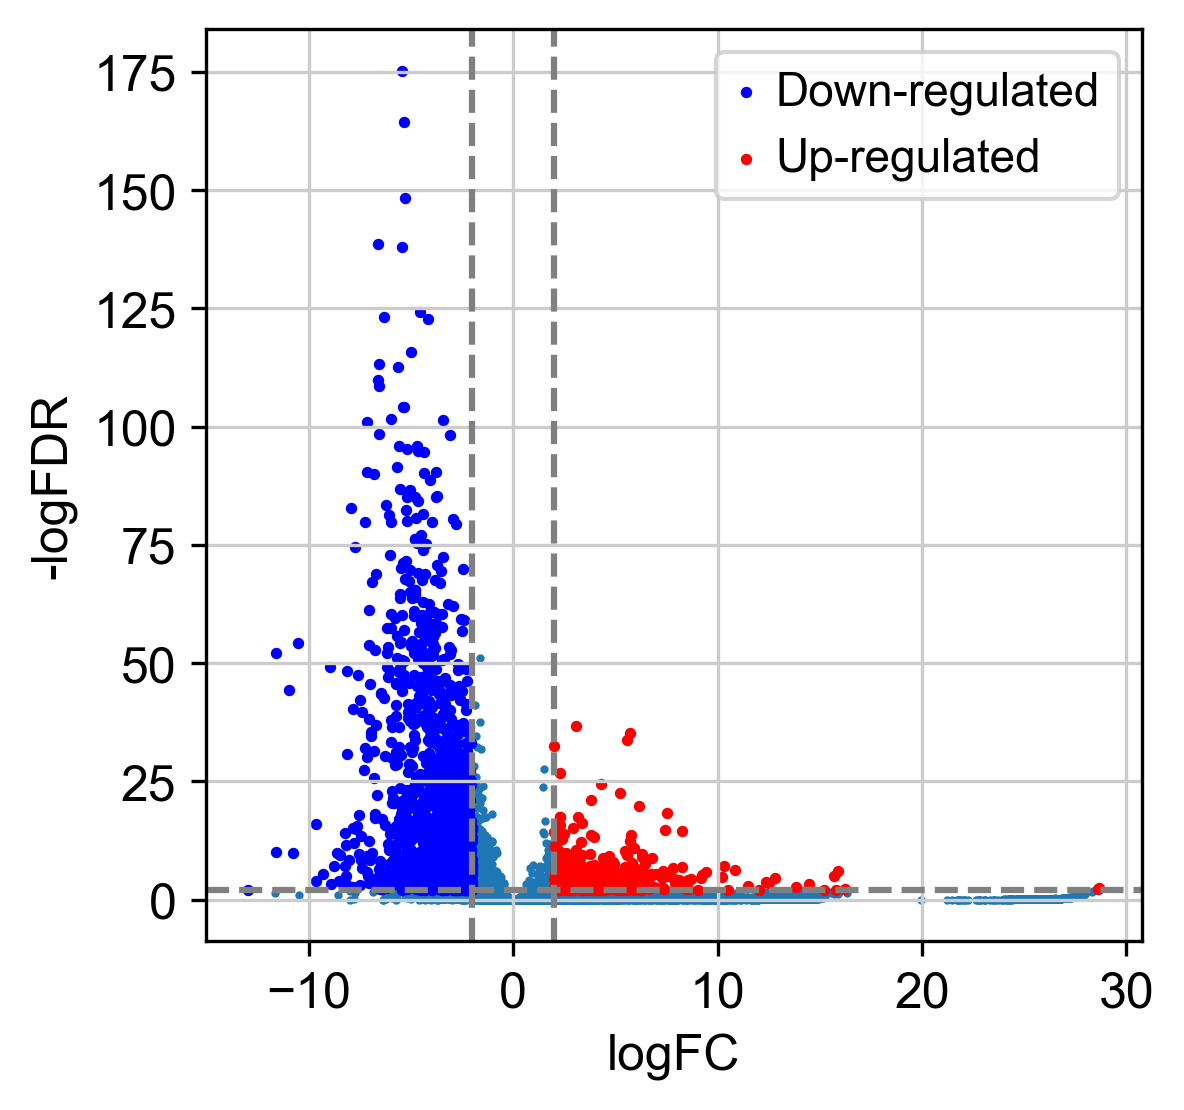

In [133]:
plt.scatter(x=df_Epi_ssGmXY['logfoldchanges'],y=df_Epi_ssGmXY['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)

# highlight down- or up- regulated genes
down = df_Epi_ssGmXY[(df_Epi_ssGmXY['logfoldchanges']<=-2)&(df_Epi_ssGmXY['pvals_adj']<=0.01)]
up = df_Epi_ssGmXY[(df_Epi_ssGmXY['logfoldchanges']>=2)&(df_Epi_ssGmXY['pvals_adj']<=0.01)]

plt.scatter(x=down['logfoldchanges'],y=down['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['logfoldchanges'],y=up['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

## **Comparison between PrE EB and PrE embryos**

**Filter cells and rank genes**

In [134]:
adata_Vrij_pre = adata_concat[adata_concat.obs['cell_type'] == 'PrE']
adata_Vrij_pre = adata_Vrij_pre[adata_Vrij_pre.obs['dataset'] == '7_Vrij']
print(adata_Vrij_pre)
adata_embr_pre = adata_concat[adata_concat.obs['cell_type'] == 'PrE']
adata_embr_pre = adata_embr_pre[adata_embr_pre.obs['dataset'] != '7_Vrij']
print(adata_embr_pre)
adata_Vrij_pre.obs['model'] = adata_Vrij_pre.n_obs * ['EB']
adata_embr_pre.obs['model'] = adata_embr_pre.n_obs * ['Embryo']

adata_Vrij_embr_pre = ad.concat([adata_Vrij_pre, adata_embr_pre], join='outer')

# Rank genes
sc.tl.rank_genes_groups(adata_Vrij_embr_pre, 'model')

View of AnnData object with n_obs × n_vars = 231 × 25154
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes', 'louvain', 'batch', 'cell_type'
    var: 'mean-new', 'std-new', 'highly_variable-new', 'means-new', 'dispersions-new', 'dispersions_norm-new', 'mt-new', 'n_cells_by_counts-new', 'mean_counts-new', 'pct_dropout_by_counts-new', 'total_counts-new', 'n_cells-new', 'mean-ref', 'std-ref', 'highly_variable-ref', 'means-ref', 'dispersions-ref', 'dispersions_norm-ref'
    uns: 'louvain_colors', 'batch_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
View of AnnData object with n_obs × n_vars = 289 × 25154
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes', 'louvain', 'batch', 'cell_type'
    var: 'mean-new', 'std-new', 'highly_variable-new', 'means-new', 'dispersions-new', 'dispersions_norm-new', 'mt-new', 'n_cells_by_counts-new', 'mean_counts-new', 'pct_dropout_by_counts-new', 

C:\Users\learogue\AppData\Local\Temp\ipykernel_6512\30320149.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_Vrij_pre.obs['model'] = adata_Vrij_pre.n_obs * ['EB']
C:\Users\learogue\AppData\Local\Temp\ipykernel_6512\30320149.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_embr_pre.obs['model'] = adata_embr_pre.n_obs * ['Embryo']


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [135]:
df = sc.get.rank_genes_groups_df(adata_Vrij_embr_pre, group="EB")

# Sort by logfoldchanges
df = df.sort_values('logfoldchanges', ascending=False)
#df.to_csv('DEG/df_EB_vs_embryos_PrE.tab', sep = '\t')

# Filtering Gm
df_PrE_ssGm = df[~df['names'].str.startswith('Gm')]
#df.to_csv('DEG/df_EB_vs_embryos_PrE_sansGm.tab', sep = '\t')

# Filter sexual genes
df_PrE_ssGmXY = df_PrE_ssGm[~df_PrE_ssGm['names'].isin(l_genes_XY)]
#df_PrE_ssGmXY.to_csv('DEG/df/df_EB_vs_embryos_PrE_sansGmXY.tab', sep = '\t')

# Filter significative data
filtered_df = df_PrE_ssGm[df_PrE_ssGm['pvals_adj'] < 0.05]

up = filtered_df[filtered_df['logfoldchanges']>=2]
print(up)
down = filtered_df[filtered_df['logfoldchanges']<=-2]
print(down)

#up.to_csv('DEG/df_Vrij/df_EB_vs_embryos_PrE_sansGmXY_upreg.tab', sep = '\t')
#down.to_csv('DEG/df_Vrij/df_EB_vs_embryos_PrE_sansGmXY_downregreg.tab', sep = '\t')

      names    scores  logfoldchanges         pvals     pvals_adj
221    Nrn1  3.060977       28.147673  2.468372e-03  5.607283e-03
19    Grem2  7.240362       16.969326  6.662781e-12  2.820050e-11
139  Nkx6-1  3.761147       16.016748  2.146159e-04  5.499081e-04
297   Foxd1  2.600475       15.115453  9.912670e-03  2.076649e-02
99    Cdh13  4.165571       14.627218  4.395455e-05  1.205312e-04
..      ...       ...             ...           ...           ...
268   Bace2  2.783047        2.034443  5.813150e-03  1.258165e-02
365  Nos1ap  2.298316        2.014436  2.241304e-02  4.424213e-02
111    Nrg2  4.012687        2.012511  7.967978e-05  2.134468e-04
26    Parvb  6.319123        2.007772  1.095477e-09  4.120776e-09
76    Capn2  4.510895        2.007225  9.951833e-06  2.890295e-05

[245 rows x 5 columns]
          names     scores  logfoldchanges          pvals      pvals_adj
23436    Col4a2 -21.668459       -2.000989   1.149750e-71   1.845617e-70
14211   Ppp1r21  -3.005789       -2.00

**Volcano plot**

C:\Users\learogue\AppData\Local\Temp\ipykernel_6512\3098258684.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=df_PrE_ssGmXY['logfoldchanges'],y=df_PrE_ssGmXY['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)


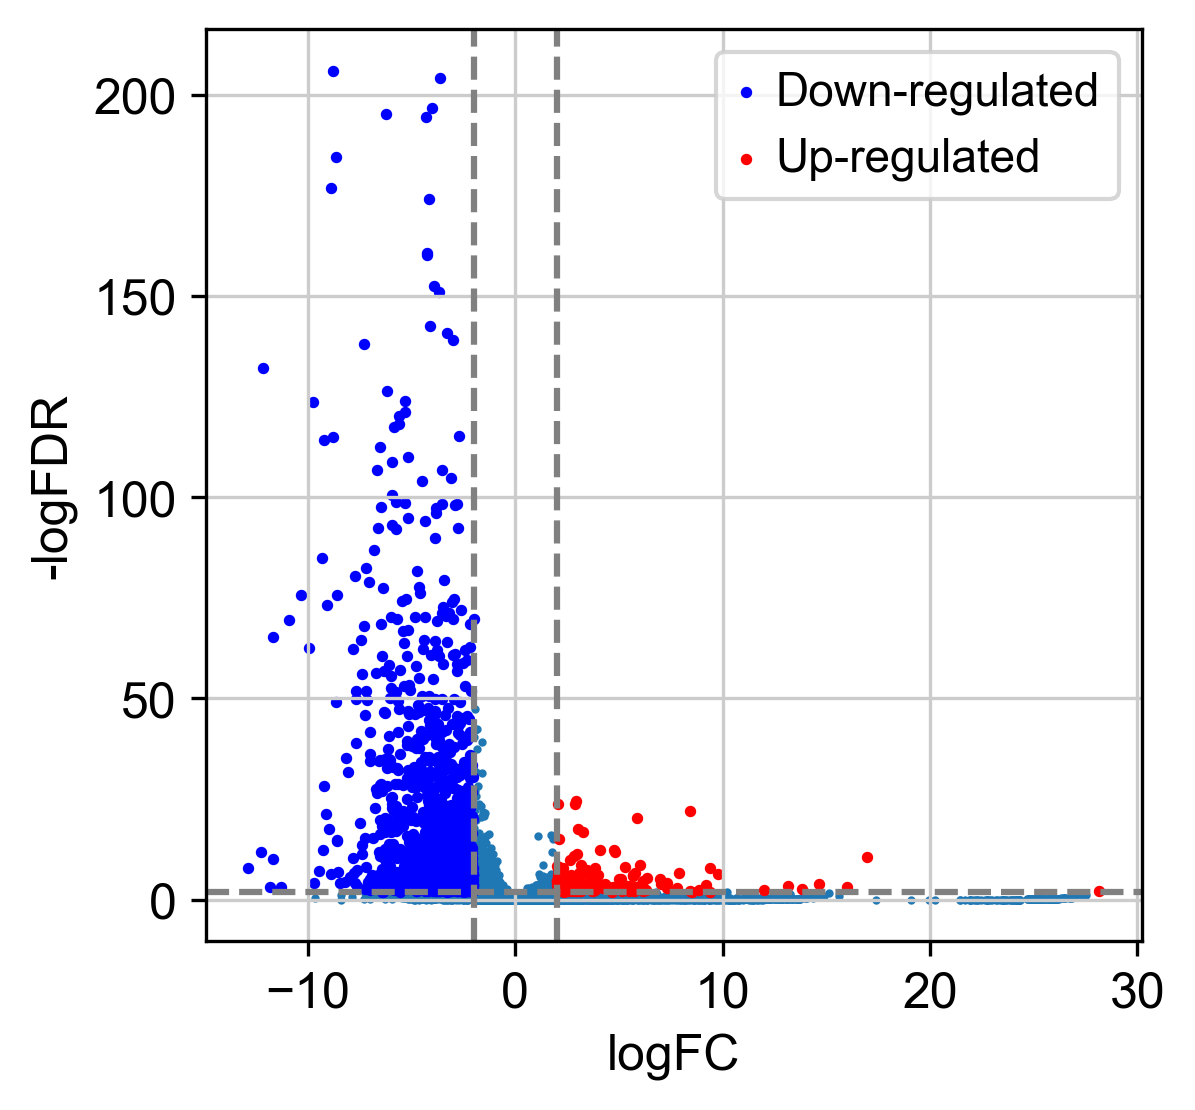

In [136]:
plt.scatter(x=df_PrE_ssGmXY['logfoldchanges'],y=df_PrE_ssGmXY['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)

# highlight down- or up- regulated genes
down = df_PrE_ssGmXY[(df_PrE_ssGmXY['logfoldchanges']<=-2)&(df_PrE_ssGmXY['pvals_adj']<=0.01)]
up = df_PrE_ssGmXY[(df_PrE_ssGmXY['logfoldchanges']>=2)&(df_PrE_ssGmXY['pvals_adj']<=0.01)]

plt.scatter(x=down['logfoldchanges'],y=down['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['logfoldchanges'],y=up['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

## **DEG between Lefty1+ cells from PrE between EB and embryos**

**Filter and sort cells and genes**

In [137]:
# DEG Lefty1 EB/embr
adata_Vrij_pre_lefty = adata_Vrij_pre[:, 'Lefty1']
print(adata_Vrij_pre_lefty.obs)
adata_embr_pre_lefty  = adata_embr_pre[:, 'Lefty1']

adata_embr_vrij_pre_lefty = ad.concat([adata_Vrij_pre_lefty, adata_embr_pre_lefty], join='outer')

# Rank genes
sc.tl.rank_genes_groups(adata_embr_vrij_pre_lefty, 'model')
df = sc.get.rank_genes_groups_df(adata_embr_vrij_pre_lefty, group="EB")

# Sort by logfoldchanges
df= df.sort_values('logfoldchanges', ascending=False)
#df.to_csv('DEG/df_EB_vs_embryos_PrE_lefty1.tab', sep = '\t')
df = df[~df['names'].isin(l_genes_XY)]

# Filter
df = df[~df['names'].str.startswith('Gm')]
#df.to_csv('DEG/df_EB_vs_embryos_PrE_sansGm_Lefty1.tab', sep = '\t')

# Filter significative data
filtered_df = df[df['pvals_adj'] < 0.05]
print(filtered_df.head(15))
print(filtered_df.tail(15))

                n_genes_by_counts  total_counts  total_counts_mt  \
SRR8883229-new               6390      162494.0          16796.0   
SRR8883230-new               6681      199429.0          17265.0   
SRR8883231-new               6984      263989.0          27410.0   
SRR8883233-new               8982      422016.0          34515.0   
SRR8883234-new               5663      108613.0           5576.0   
...                           ...           ...              ...   
SRR8883567-new               6193      104978.0           9176.0   
SRR8883568-new               8108      292916.0          22454.0   
SRR8883569-new               7862      229099.0          18864.0   
SRR8883578-new               7409      125135.0           9899.0   
SRR8883590-new               7265      155481.0          10363.0   

                pct_counts_mt dataset  n_genes louvain batch cell_type model  
SRR8883229-new      10.336382  7_Vrij     6390       0   new       PrE    EB  
SRR8883230-new       8.65

C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


**Volcano plot**

C:\Users\learogue\AppData\Local\Temp\ipykernel_6512\2529538121.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=df['logfoldchanges'],y=df['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)


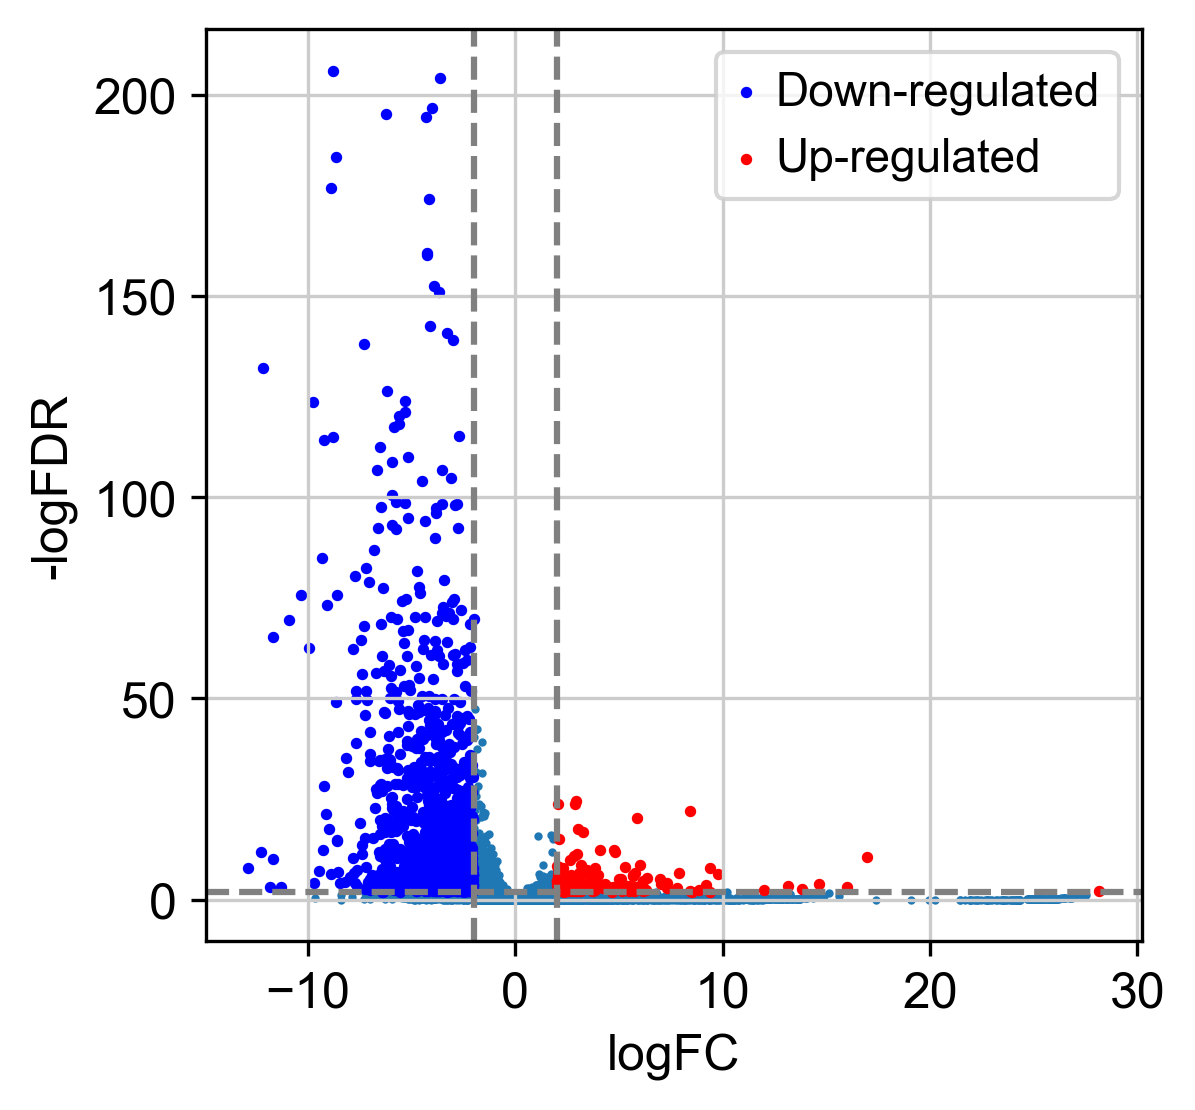

In [138]:
plt.scatter(x=df['logfoldchanges'],y=df['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)

# highlight down- or up- regulated genes
down = df[(df['logfoldchanges']<=-2)&(df['pvals_adj']<=0.01)]
up = df[(df['logfoldchanges']>=2)&(df['pvals_adj']<=0.01)]

plt.scatter(x=down['logfoldchanges'],y=down['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['logfoldchanges'],y=up['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

## **DEG between Lefty1+ cells from PrE between EB and embryos**

**Filter and sort cells and genes**

In [139]:
# DEG LEfty2 EB/embr
adata_Vrij_pre_lefty = adata_Vrij_pre[:, 'Lefty2']

adata_embr_pre_lefty  = adata_embr_pre[:, 'Lefty2']

adata_embr_vrij_pre_lefty = ad.concat([adata_Vrij_pre_lefty, adata_embr_pre_lefty], join='outer')

# Rank genes
sc.tl.rank_genes_groups(adata_embr_vrij_pre_lefty, 'model')

# Transform into df
df = sc.get.rank_genes_groups_df(adata_embr_vrij_pre_lefty, group="EB")

# Sort by logfoldchanges
df= df.sort_values('logfoldchanges', ascending=False)
#df.to_csv('DEG/df_EB_vs_embryos_PrE_lefty2.tab', sep = '\t')

# Filter
df = df[~df['names'].str.startswith('Gm')]
#df.to_csv('DEG/df_EB_vs_embryos_PrE_sansGm_Lefty2.tab', sep = '\t')

# Filter significative data to add gene names on volcano plot
filtered_df = df[df['pvals_adj'] < 0.05]
print(filtered_df.head(15))
print(filtered_df.tail(15))

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
      names    scores  logfoldchanges         pvals     pvals_adj
221    Nrn1  3.060977       28.147673  2.468372e-03  5.607283e-03
19    Grem2  7.240362       16.969326  6.662781e-12  2.820050e-11
139  Nkx6-1  3.761147       16.016748  2.146159e-04  5.499081e-04
297   Foxd1  2.600475       15.115453  9.912670e-03  2.076649e-02
99    Cdh13  4.165571       14.627218  4.395455e-05  1.205312e-04
368    Ntn4  2.287432       14.275431  2.307961e-02  4.543667e-02
277   Ajap1  2.746057       14.011792  6.508694e-03  1.399074e-02
180   Kcnq5  3.407177       13.842686  7.746990e-04  1.868518e-03
367   Nr4a3  2.289383 

C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


**Volcano plot**

C:\Users\learogue\AppData\Local\Temp\ipykernel_6512\2529538121.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=df['logfoldchanges'],y=df['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)


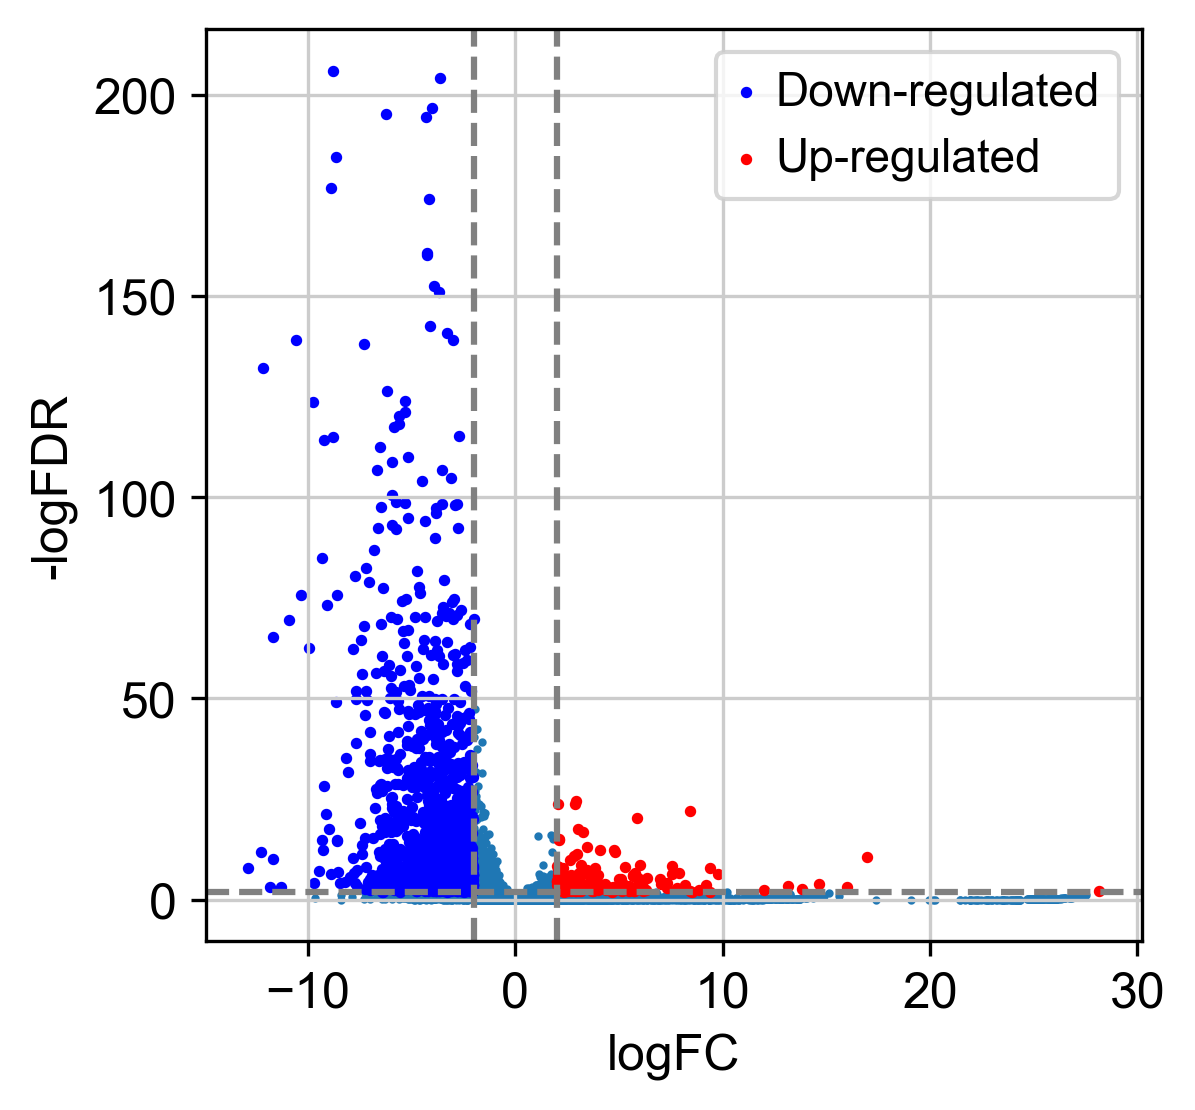

In [140]:
plt.scatter(x=df['logfoldchanges'],y=df['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)

# highlight down- or up- regulated genes
down = df[(df['logfoldchanges']<=-2)&(df['pvals_adj']<=0.01)]
up = df[(df['logfoldchanges']>=2)&(df['pvals_adj']<=0.01)]

plt.scatter(x=down['logfoldchanges'],y=down['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['logfoldchanges'],y=up['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()